In [112]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import copy

from tqdm import tqdm
import glob
from PIL import Image

In [120]:
class Image():
    
    def __init__(self, image, landmarks):
        self.image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.original_image = copy.deepcopy(self.image)
        self.landmarks = landmarks
        self.hash = hash(self)
        
    def getImage(self):
        return self.image
    
    def clearImage(self):
        self.image= copy.deepcopy(self.original_image)
        return self.image
    
    def getLandmarks(self):
        return self.landmarks
    
    def getHash(self):
        return self.hash

In [121]:
def getLandmarksForImage(imagePath):
    cur_landmark = "/".join(str(imagePath).rsplit('/',3)[-3:])[:-4]
    landmark_path = ck_landmarks_path + '/' + cur_landmark + '_landmarks.txt'
    landmarks = np.loadtxt(landmark_path)
    return landmarks


def view_landmarks(landmarks):
    xs, ys = list(zip(*landmarks))
    plt.scatter(xs, ys, color='r')
    return 

In [122]:
base_path = "../Data/"

In [123]:
ck_data_path = base_path + 'CK_CK+/CK+/cohn-kanade-images'
ck_landmarks_path = base_path + 'CK_CK+/CK+/Landmarks'
ck_image_files = glob.glob(ck_data_path+'/**/*.png', recursive=True)

ck_image_files = ck_image_files[:500]

In [125]:
images = []

with tqdm(total=len(ck_image_files), desc="Processing entries") as pbar:
    for i, ck_image in enumerate(ck_image_files):

        image = cv2.imread(ck_image)
        landmarks = getLandmarksForImage(ck_image)
        images.append(Image(image, landmarks))
        
        pbar.update(1)

Processing entries: 100%|██████████| 500/500 [00:02<00:00, 169.89it/s]


# Compute average landmark position

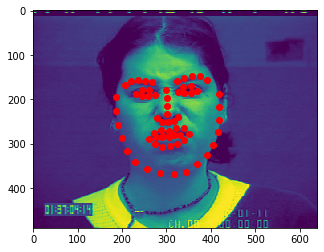

In [126]:
plt.imshow(images[0].getImage())
view_landmarks(images[0].getLandmarks())

In [127]:
numImages = len(images)

avgLandmarks = (images[0].getLandmarks() / numImages)

for image in images[1:]:
    avgLandmarks += (image.getLandmarks()) / numImages

## Transform images to shape free variant

In [128]:
def appendLastRowAsCol(npMatrix):
    return np.c_[npMatrix[:-1,:].T, np.array([npMatrix[-1,:]]).T ]

In [129]:
def pairPlot(im1, im2, clear_figure=False, title=''):
    if not clear_figure:
        plt.figure()
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

    fig.suptitle(title, fontsize=16)
    
def getTrianglePts(triangle_points_array):
    return (tuple(triangle_points_array[0:2]), tuple(triangle_points_array[2:4]), tuple(triangle_points_array[4:6]))

def getTriangleImage(im, triangle_points_array):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    triangle = np.array([pt1, pt2, pt3])
    
    (t_x, t_y, t_w, t_h) = cv2.boundingRect(triangle)
    triangle_im = im[t_y : t_y+t_h, t_x : t_x+t_w]
    triangle_mask = np.zeros_like(triangle_im)

    triangle_mask_fill_points = np.array([
            [pt1[0] - t_x, pt1[1] - t_y],
            [pt2[0] - t_x, pt2[1] - t_y],
            [pt3[0] - t_x, pt3[1] - t_y]
        ], np.int32)
    cv2.fillConvexPoly(triangle_mask, triangle_mask_fill_points, (255,255,255))
        
    cropped_triangle = cv2.bitwise_and(triangle_mask, triangle_im)
    return cropped_triangle

def drawTriangle(im, triangle_points_array, color):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    
    cv2.line(im, pt1, pt2, color, 2)
    cv2.line(im, pt1, pt3, color, 2)
    cv2.line(im, pt3, pt2, color, 2)

[[227.3369  204.26794]
 [186.95149 211.93651]
 [205.02913 184.6742 ]] [[227.3369  204.26794]
 [186.95149 211.93651]
 [205.02913 184.6742 ]]


<Figure size 432x288 with 0 Axes>

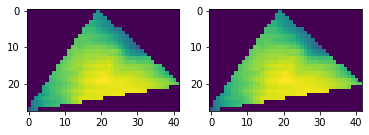

<Figure size 432x288 with 0 Axes>

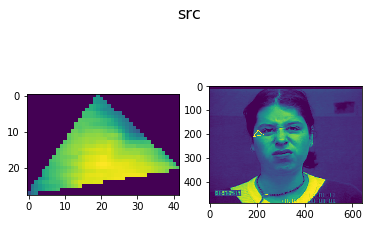

<Figure size 432x288 with 0 Axes>

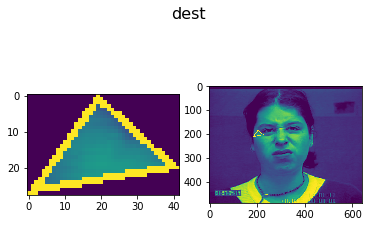

In [142]:
DRAW_EXAMPLE = True

dest = list(map(lambda x: tuple(x),avgLandmarks))
# dest = list(map(lambda x: tuple(x),images[100].getLandmarks()))

for image in images[:]:
    src = list(map(lambda x: tuple(x),image.getLandmarks()))
#     tform = cv2.estimateAffine2D(src,dest)
    image.clearImage()
    im = image.getImage()
    im_shape = im.shape

    rect = (0,0,im_shape[1],im_shape[0])
    subdiv = cv2.Subdiv2D(rect)

    subdiv.insert(dest)
    triangles_dest = subdiv.getTriangleList()

    subdiv.insert(src)
    triangles_src = subdiv.getTriangleList()
    
    for (src_triangle, dest_triangle) in zip(triangles_src, triangles_dest):
        src_triangle_points = np.array(list(map(lambda x : list(x),getTrianglePts(src_triangle))), np.float32)
        dest_triangle_points = np.array(list(map(lambda x : list(x),getTrianglePts(dest_triangle))), np.float32)
        
        print(src_triangle_points, dest_triangle_points)

        M = cv2.getAffineTransform(src_triangle_points, dest_triangle_points)
        
        src_triangle_image = getTriangleImage(im, src_triangle)
        warped_triangle_shape = (src_triangle_image.shape[1], src_triangle_image.shape[0])        
        warpted_triangle = cv2.warpAffine(src_triangle_image, M, warped_triangle_shape)
        
        pairPlot(src_triangle_image, warpted_triangle)
        
#         break
        if DRAW_EXAMPLE:
            
            drawTriangle(im, src_triangle, (255,0,0))
            pairPlot(src_triangle_image, im, title='src')

            im = image.clearImage()
            drawTriangle(im, dest_triangle, (255,0,0))
            dest_triangle_image = getTriangleImage(im, dest_triangle)
            pairPlot(dest_triangle_image, im, title='dest')
            break

    if DRAW_EXAMPLE:
        break